# 프로젝트 설명

본 프로젝트는 당뇨병 수치 데이터와 캐글(Kaggle) 경진대회에서 제공하는 자전거 대여량 데이터셋에 다변량 선형회귀 모델을 적용하여 예측정확도를 계산해보고 예측한 데이터를 시각화 해보고자 한다. 당뇨병 수치 데이터를 사용할 때는 manually 회귀 모델을 설계하고 손실함수와 기울기를 계산하는 함수를 구현해보고, 자전거 대여량 데이터셋에는 sci-kit leanrn 라이브러리의 LinearRegression메서드를 사용해서 다변량 선형회귀 모델의 예측 정확도를 계산하고 시각화했다.

### 패키지 임포트

In [512]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### 손수 설계하는 선형회귀, 당뇨병 수치를 맞춰보자!

#### 데이터 가져오기

In [513]:
diabetes = load_diabetes()
diabetes.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [514]:
df_X= diabetes.data
df_y = diabetes.target
print(df_X.shape)
print(df_y.shape)

(442, 10)
(442,)


#### 상관관계 확인
목표하고자하는 loss 값에 도달하기위해 target 데이터와 상관관계가 적은 특성을 제거하면 loss가 줄을거라고 생각해서 상관관계를 확인했다.
target 데이터를 예측하는데 방해가 되는, 불필요한 특성을 제거하기 위한 기준으로 상관관계를 활용했다.

In [515]:
data = load_diabetes(as_frame=True)

In [516]:
data['data']['target'] = data['target']
data['data']

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930,220.0


In [517]:
data['data'].corrwith(data['data']['target'])

age       0.187889
sex       0.043062
bmi       0.586450
bp        0.441484
s1        0.212022
s2        0.174054
s3       -0.394789
s4        0.430453
s5        0.565883
s6        0.382483
target    1.000000
dtype: float64

상관관계의 절대값이 적은 컬럼을 제거하고 돌려봤을 때, loss값이 유의미하게 줄어드는 결과를 확인하지 못했지만, 정답데이터와 예측한 데이터를 시각화 할 때 직관적으로 양의 상관관계가 있는 것이 확인되었다.

In [518]:
#df_X = np.delete(df_X, [0,1,4,5],axis =1)

#### 모델에 입력할 데이터 X 준비하기

In [519]:
df_X = np.array(df_X)
df_X

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

#### 모델에 예측할 데이터 y 준비하기

In [520]:
df_y = np.array(df_y)
df_y

array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
        69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
        68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
        87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
       259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
       128.,  52.,  37., 170., 170.,  61., 144.,  52., 128.,  71., 163.,
       150.,  97., 160., 178.,  48., 270., 202., 111.,  85.,  42., 170.,
       200., 252., 113., 143.,  51.,  52., 210.,  65., 141.,  55., 134.,
        42., 111.,  98., 164.,  48.,  96.,  90., 162., 150., 279.,  92.,
        83., 128., 102., 302., 198.,  95.,  53., 134., 144., 232.,  81.,
       104.,  59., 246., 297., 258., 229., 275., 281., 179., 200., 200.,
       173., 180.,  84., 121., 161.,  99., 109., 115., 268., 274., 158.,
       107.,  83., 103., 272.,  85., 280., 336., 281., 118., 317., 235.,
        60., 174., 259., 178., 128.,  96., 126., 28

#### train 데이터와 test 데이터로 분리하기

In [521]:
train_input, test_input, train_target, test_target = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

#### 모델 준비하기

In [522]:
np.random.seed(42)
num_feature = train_input.shape[1]
W = np.random.rand(num_feature)
b = np.random.rand()

def model(X, W, b):
    predictions = 0
    for i in range(num_feature):
        predictions += X[:, i] * W[i]
    predictions += b
    return predictions

In [523]:
def MSE(a, b):
    mse = ((a - b) ** 2).mean()
    return mse

In [524]:
def loss(X, W, b, y):
    predictions = model(X, W, b)
    L = MSE(predictions, y)
    return L

In [525]:
loss(train_input, W, b, train_target)

29690.148096407873

In [526]:
def gradient(X, W, b, y):
    N = len(W)
    
    y_pred = model(X, W, b)
    
    dW = 1/N * 2 * X.T.dot(y_pred - y)
        
    db = 2 * (y_pred - y).mean()
    return dW, db

In [527]:
LEARNING_RATE = 0.01

In [528]:
losses = []

for i in range(1, 1001):
    dW, db = gradient(train_input, W, b, train_target)
    W -= LEARNING_RATE * dW
    b -= LEARNING_RATE * db
    L = loss(train_input, W, b, train_target)
    losses.append(L)
    if i % 100 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

Iteration 100 : Loss 4688.9455
Iteration 200 : Loss 3674.4467
Iteration 300 : Loss 3388.8479
Iteration 400 : Loss 3233.7693
Iteration 500 : Loss 3135.8683
Iteration 600 : Loss 3069.6513
Iteration 700 : Loss 3023.3220
Iteration 800 : Loss 2990.3260
Iteration 900 : Loss 2966.5649
Iteration 1000 : Loss 2949.3086


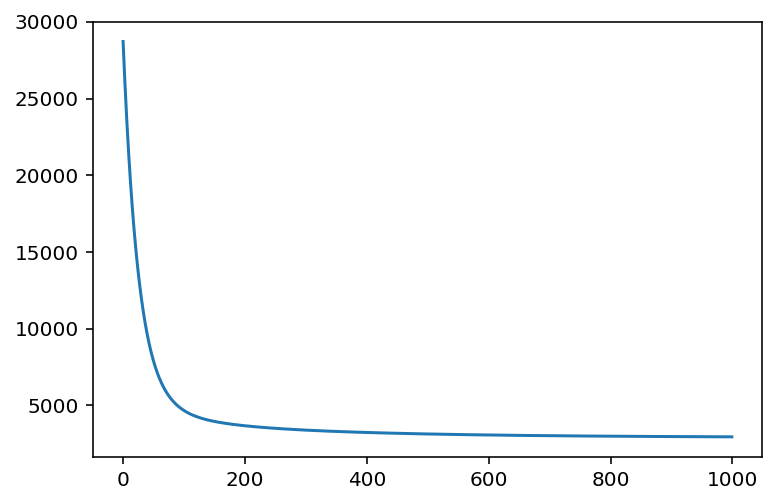

In [529]:
plt.plot(losses)
plt.show()

In [530]:
W, b

(array([  48.22812489, -170.02777021,  470.55540051,  306.64069582,
         -51.57093654, -100.13790088, -209.74077226,  145.38602918,
         350.83664371,  133.04487253]),
 151.49096064317663)

#### test 데이터에 대한 성능 확인하기

In [531]:
prediction = model(test_input, W, b)
mse = loss(test_input, W, b, test_target)
mse

2867.311487959944

#### 정답 데이터와 예측한 데이터 시각화하기

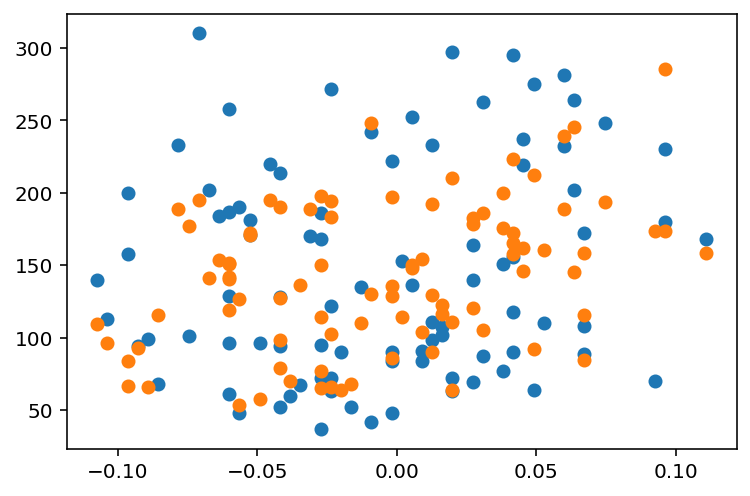

In [532]:
plt.scatter(test_input[:, 0], test_target)
plt.scatter(test_input[:, 0], prediction)
plt.show()

### 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?

#### 데이터 가져오기

In [533]:
bike_sharing = pd.read_csv("/aiffel/aiffel/bike_regression/data/train.csv")
bike_sharing

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


#### datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기

In [534]:
bike_sharing.datetime = pd.to_datetime(bike_sharing.datetime)
bike_sharing['year'] = bike_sharing.datetime.dt.year
bike_sharing['month'] = bike_sharing.datetime.dt.month
bike_sharing['day'] = bike_sharing.datetime.dt.day
bike_sharing['hour'] = bike_sharing.datetime.dt.hour
bike_sharing['minute'] = bike_sharing.datetime.dt.minute
bike_sharing['second'] = bike_sharing.datetime.dt.second

'''요일 정보 가져오기
출처 : https://god9ma.tistory.com/27

프로젝트 이름대로
1) 날씨 좋은
2) 월요일
3) 오후 세 시에
자전거 대여량을 확인하기 위해 추가적으로 요일정보를 가져왔다.
'''
bike_sharing['dayofweek']= bike_sharing["datetime"].dt.dayofweek

bike_sharing

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,0,0,2
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,0,0,2
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,0,0,2
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,0,0,2


#### year, month, day, hour, minute, second 데이터 개수 시각화하기

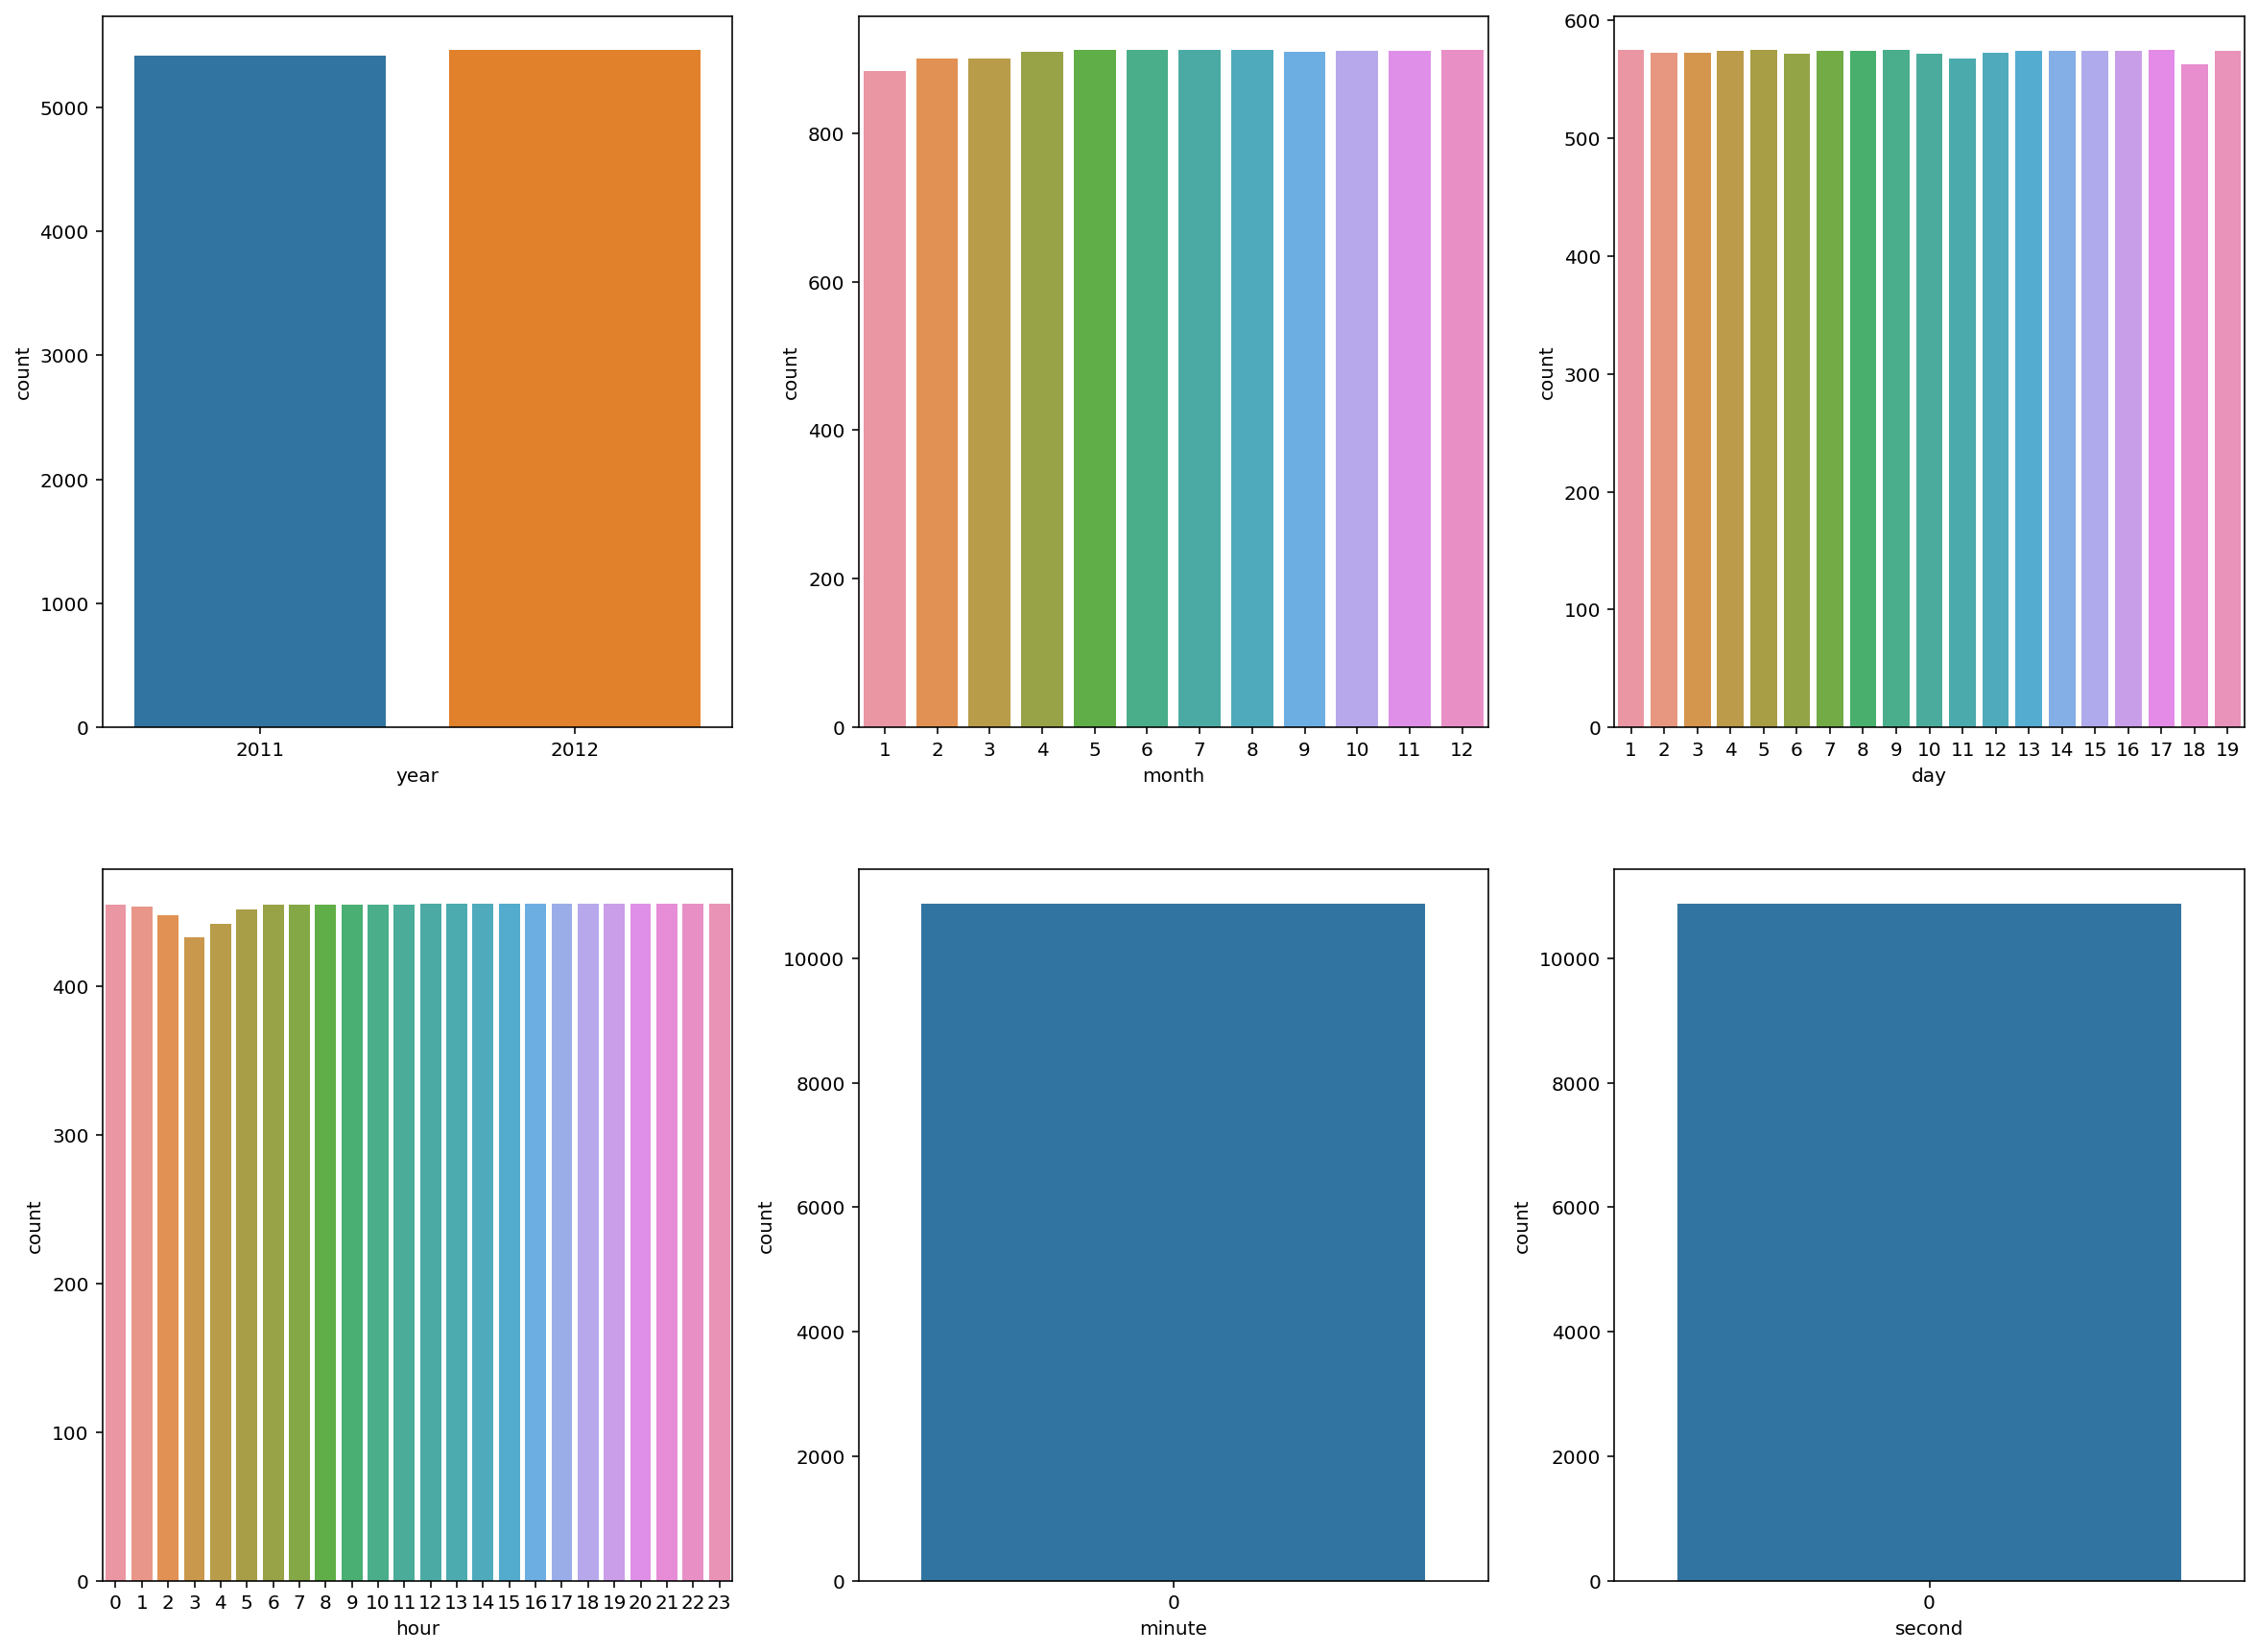

In [535]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(2,3,1)
sns.countplot(x = 'year', data = bike_sharing)

ax2 = fig.add_subplot(2,3,2)
sns.countplot(x = 'month', data = bike_sharing)

ax3 = fig.add_subplot(2,3,3)
sns.countplot(x = 'day', data = bike_sharing)

ax4 = fig.add_subplot(2,3,4)
sns.countplot(x = 'hour', data = bike_sharing)

ax5 = fig.add_subplot(2,3,5)
sns.countplot(x = 'minute', data = bike_sharing)

ax1 = fig.add_subplot(2,3,6)
sns.countplot(x = 'second', data = bike_sharing)

plt.show()

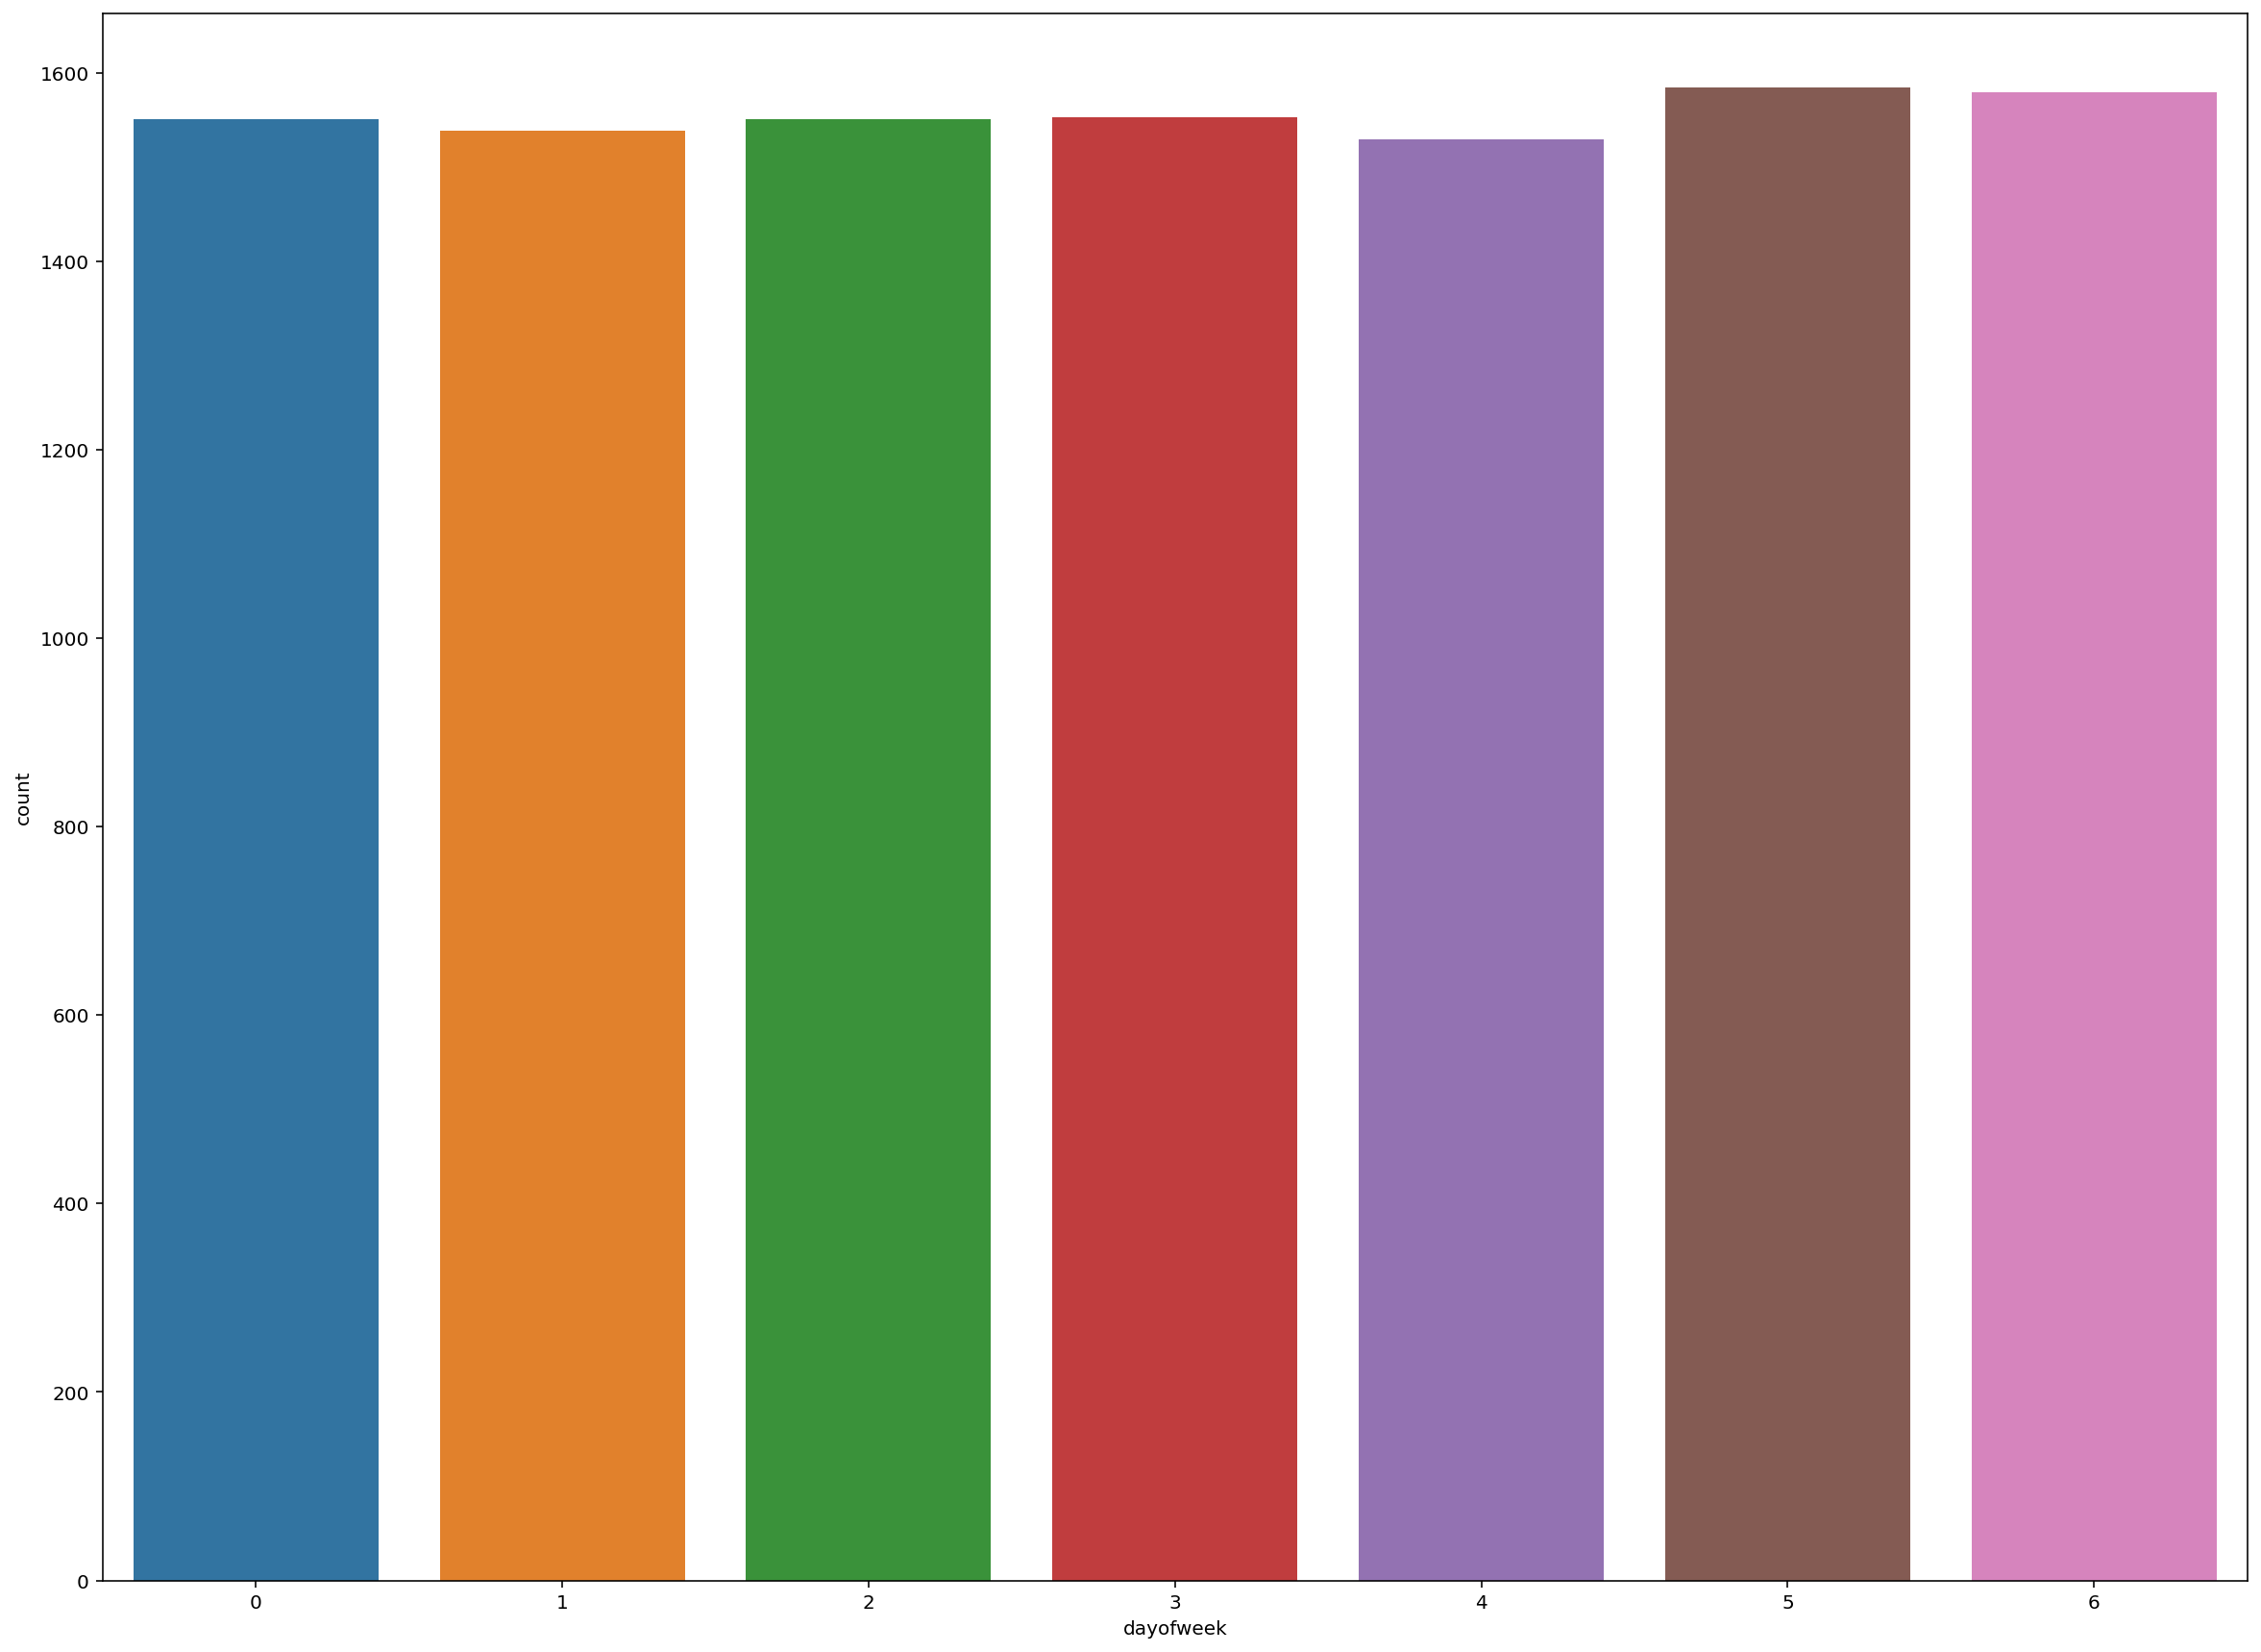

In [536]:
# 요일별로 데이터 크기 확인
# 요일 - 0(월), 1(화), 2(수), 3(목), 4(금), 5(토), 6(일)
fig = plt.figure(figsize=(20,15))
sns.countplot(x = 'dayofweek', data = bike_sharing)
plt.show()

#### X, y 컬럼 선택 및 train/test 데이터 분리

In [537]:
bike_sharing

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,0,0,2
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,0,0,2
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,0,0,2
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,0,0,2


In [538]:
'''
datetime 컬럼은 6개의 속성으로 나눠서 원핫 인코딩했으므로 필요가 없고,
casual과 registered컬럼은 합치면 count가 되기 때문에 삭제했다.
출처 : https://dsbook.tistory.com/328
'''
bike_sharing.drop(columns=["datetime", "casual","registered"],inplace=True)
bike_sharing

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minute,second,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0,0,0,5
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1,0,0,5
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2,0,0,5
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3,0,0,5
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19,0,0,2
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20,0,0,2
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21,0,0,2
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22,0,0,2


In [556]:
X = bike_sharing.drop(columns='count')
y = bike_sharing['count']
print(X.shape)
print(y.shape)

(10886, 15)
(10886,)


#### X, y 컬럼 선택 및 train/test 데이터 분리

In [541]:
train_input, test_input, train_target, test_target = train_test_split(X, y, random_state = 42)

#### LinearRegression 모델 학습

In [542]:
lr = LinearRegression()
lr.fit(train_input, train_target)

LinearRegression()

#### 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산

In [543]:
pred = lr.predict(test_input)

In [557]:
mse = mean_squared_error(test_target, pred)
rmse = mean_squared_error(test_target, pred)**0.5
print(mse)
print(rmse)

20090.29853314087
141.74025022251396


#### x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기

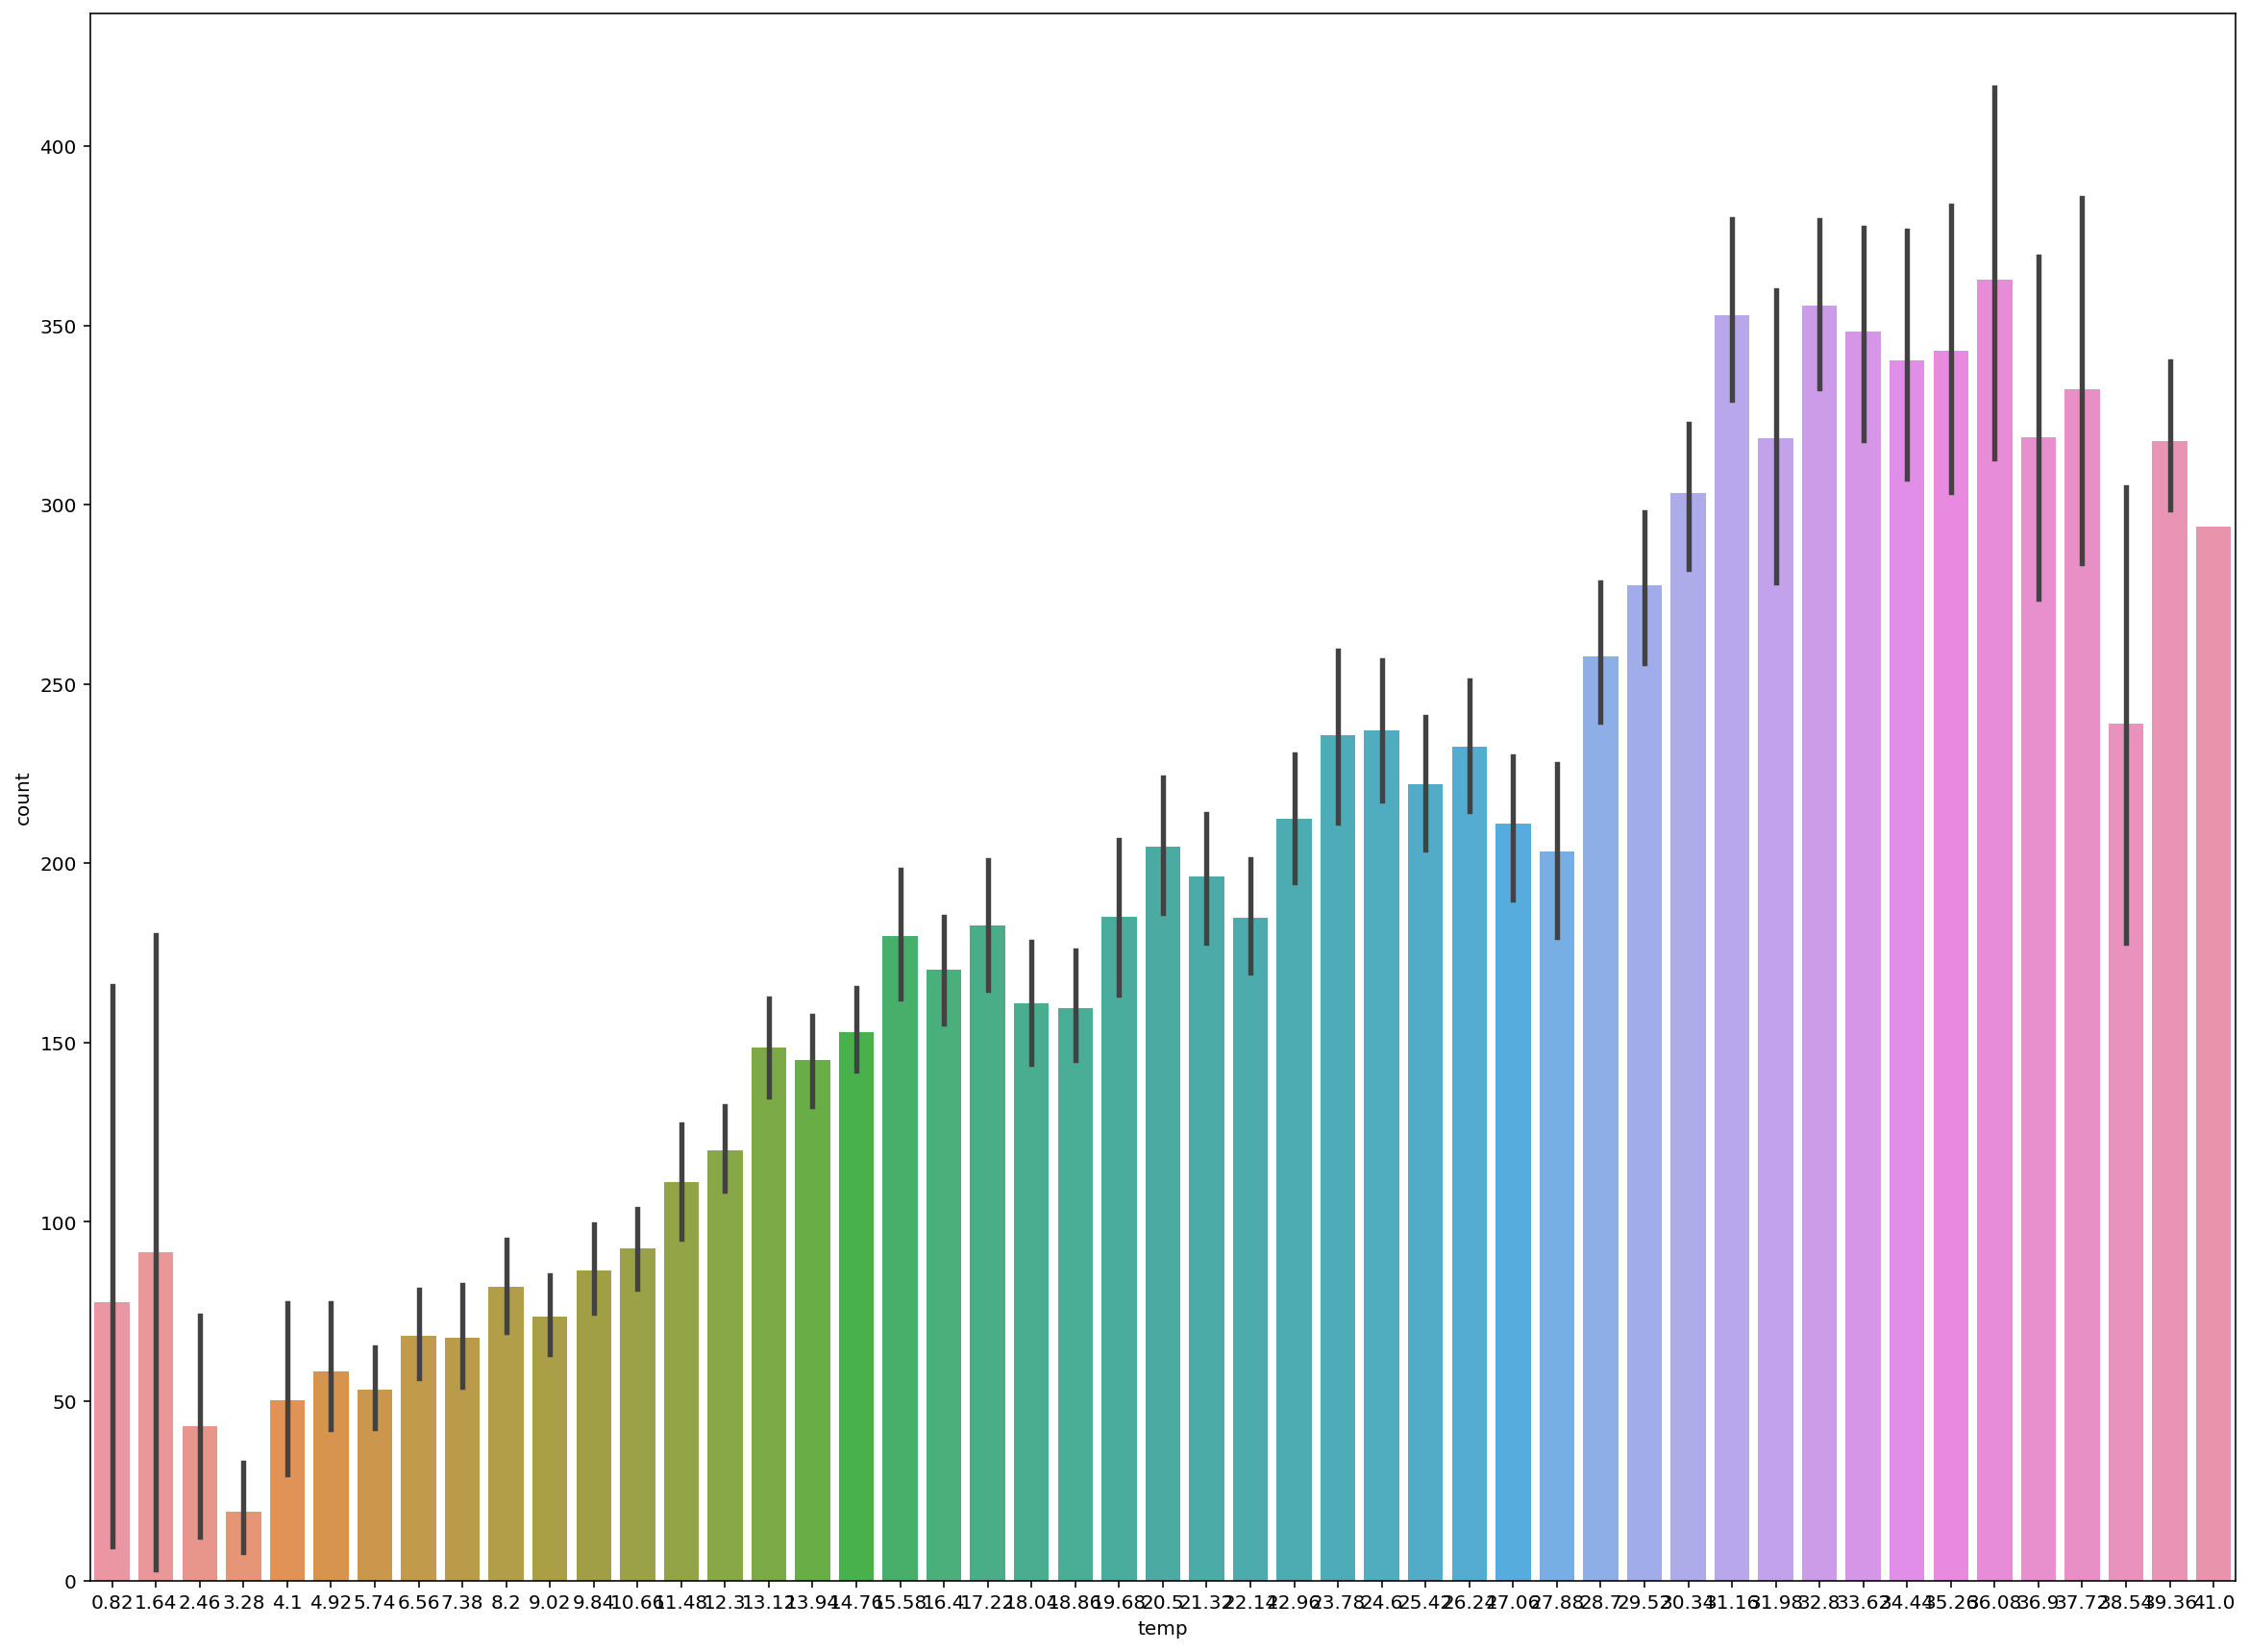

In [547]:
fig = plt.figure(figsize=(20,15))
sns.barplot( x = bike_sharing['temp'], y = bike_sharing['count'] )
plt.show()

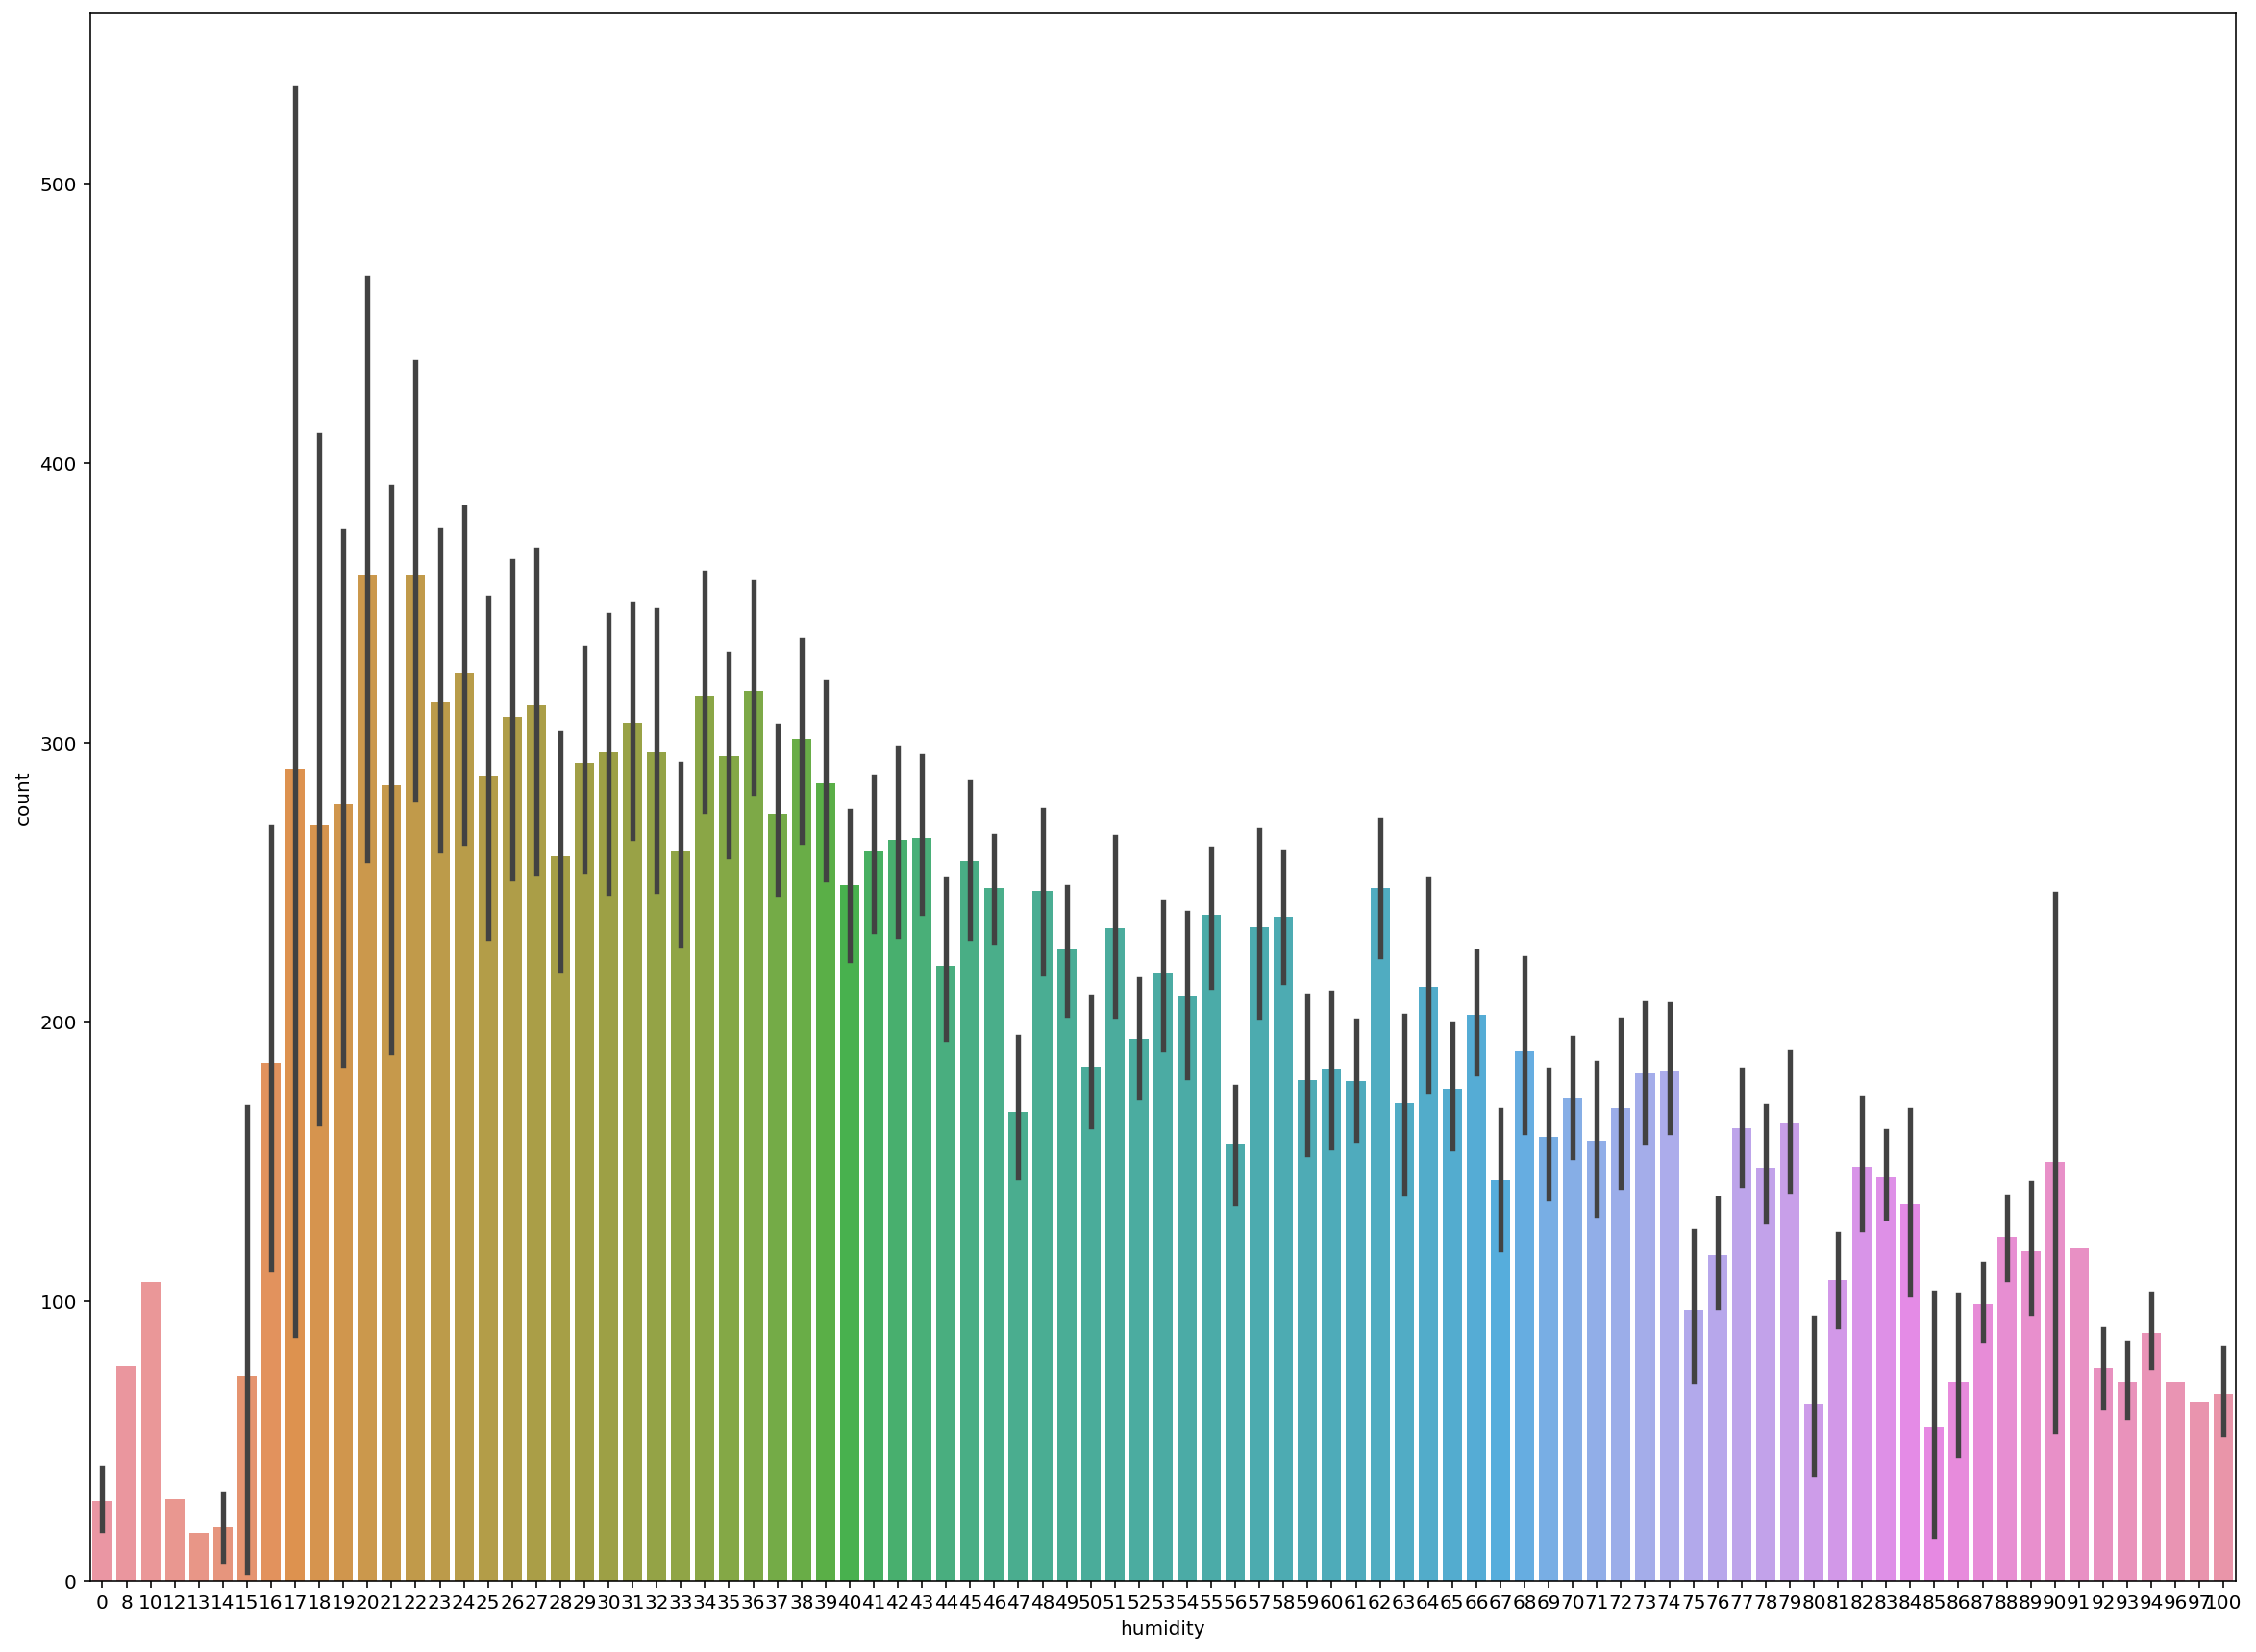

In [548]:
fig = plt.figure(figsize=(20,15))
sns.barplot( x = bike_sharing['humidity'], y = bike_sharing['count'] )
plt.show()

In [549]:
bike_sharing.corrwith(bike_sharing['count'])

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
count         1.000000
year          0.260403
month         0.166862
day           0.019826
hour          0.400601
minute             NaN
second             NaN
dayofweek    -0.002283
dtype: float64

#### 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?

In [550]:
good_day = bike_sharing[ (bike_sharing["weather"] == 1) & (bike_sharing["dayofweek"] == 0) & (bike_sharing["hour"] == 15) ]
good_day

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,minute,second,dayofweek
60,1,0,1,1,10.66,12.120,30,16.9979,72,2011,1,3,15,0,0,0
750,1,0,1,1,22.96,26.515,21,43.9989,90,2011,2,14,15,0,0,0
1034,1,0,1,1,13.94,15.150,31,26.0027,96,2011,3,7,15,0,0,0
1197,1,0,1,1,15.58,19.695,37,11.0014,101,2011,3,14,15,0,0,0
1410,2,0,1,1,31.16,33.335,23,36.9974,143,2011,4,4,15,0,0,0
1577,2,0,1,1,30.34,33.335,48,35.0008,141,2011,4,11,15,0,0,0
1817,2,0,1,1,27.06,31.060,61,12.9980,155,2011,5,2,15,0,0,0
1985,2,0,1,1,25.42,31.060,41,15.0013,199,2011,5,9,15,0,0,0
2153,2,0,1,1,29.52,33.335,51,0.0000,165,2011,5,16,15,0,0,0
2369,2,0,1,1,32.80,34.850,29,12.9980,165,2011,6,6,15,0,0,0


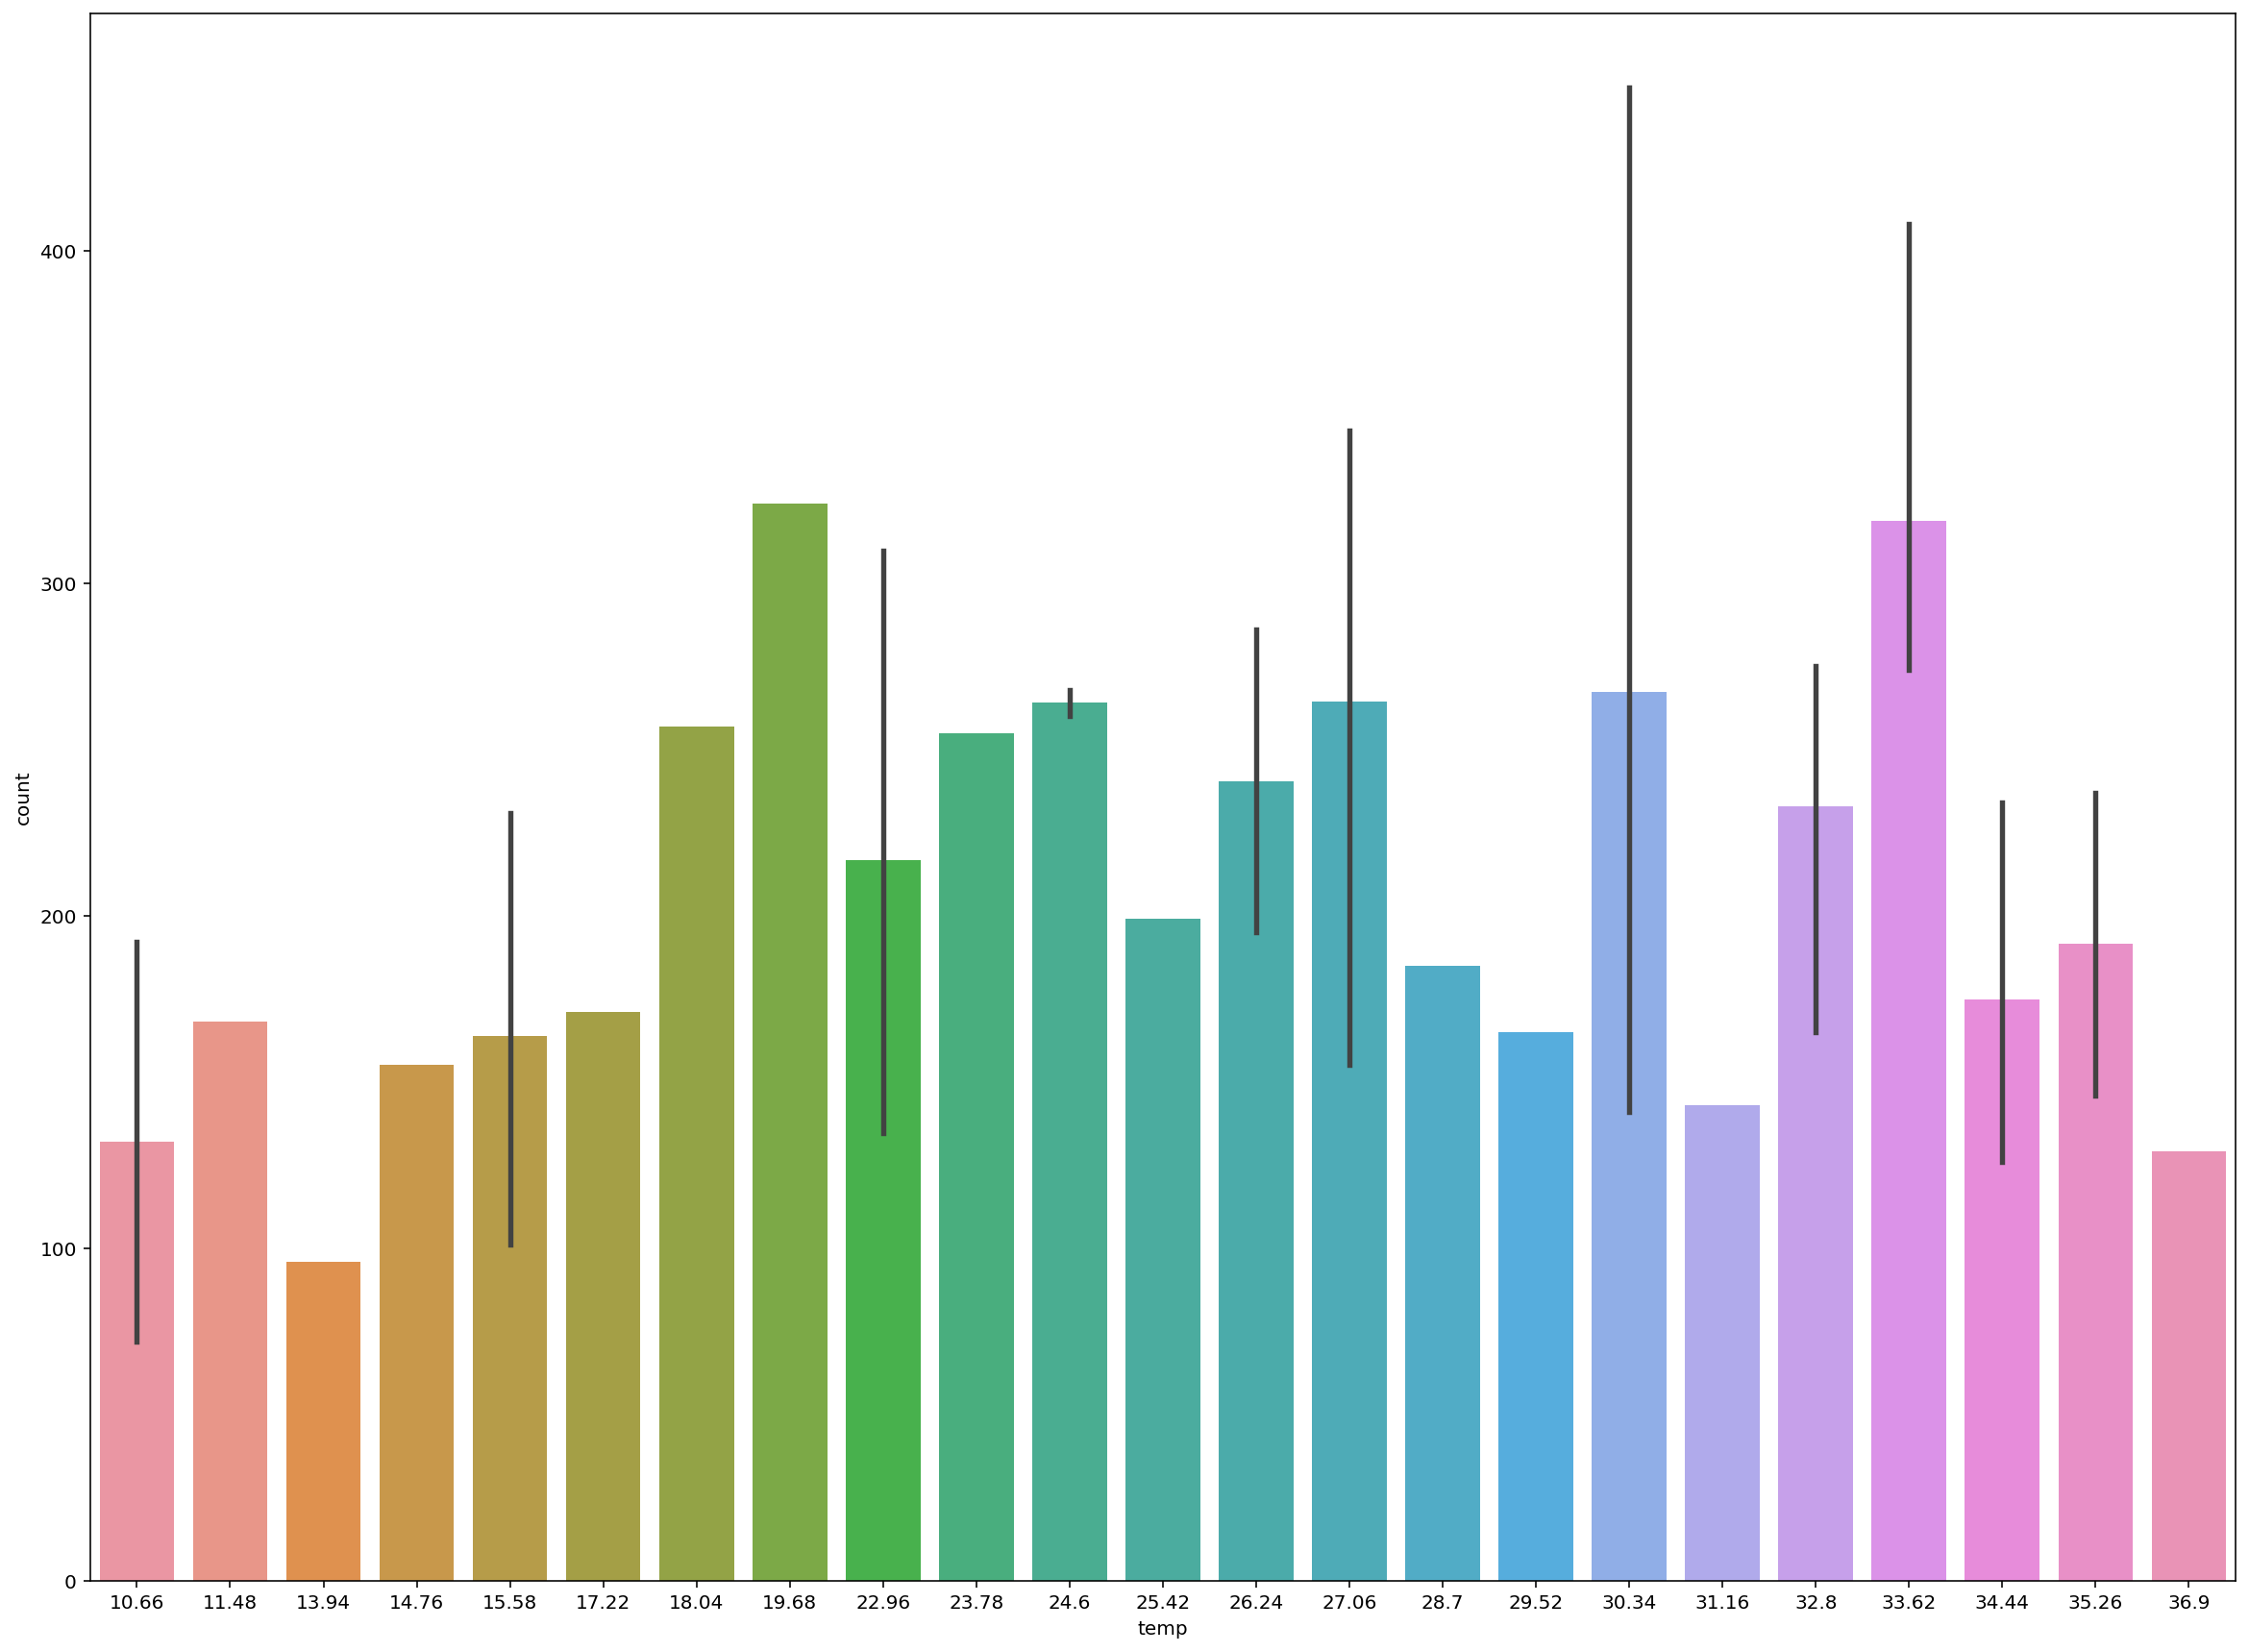

In [552]:
fig = plt.figure(figsize=(20,15))
sns.barplot( x = good_day['temp'], y = good_day['count'] )
plt.show()

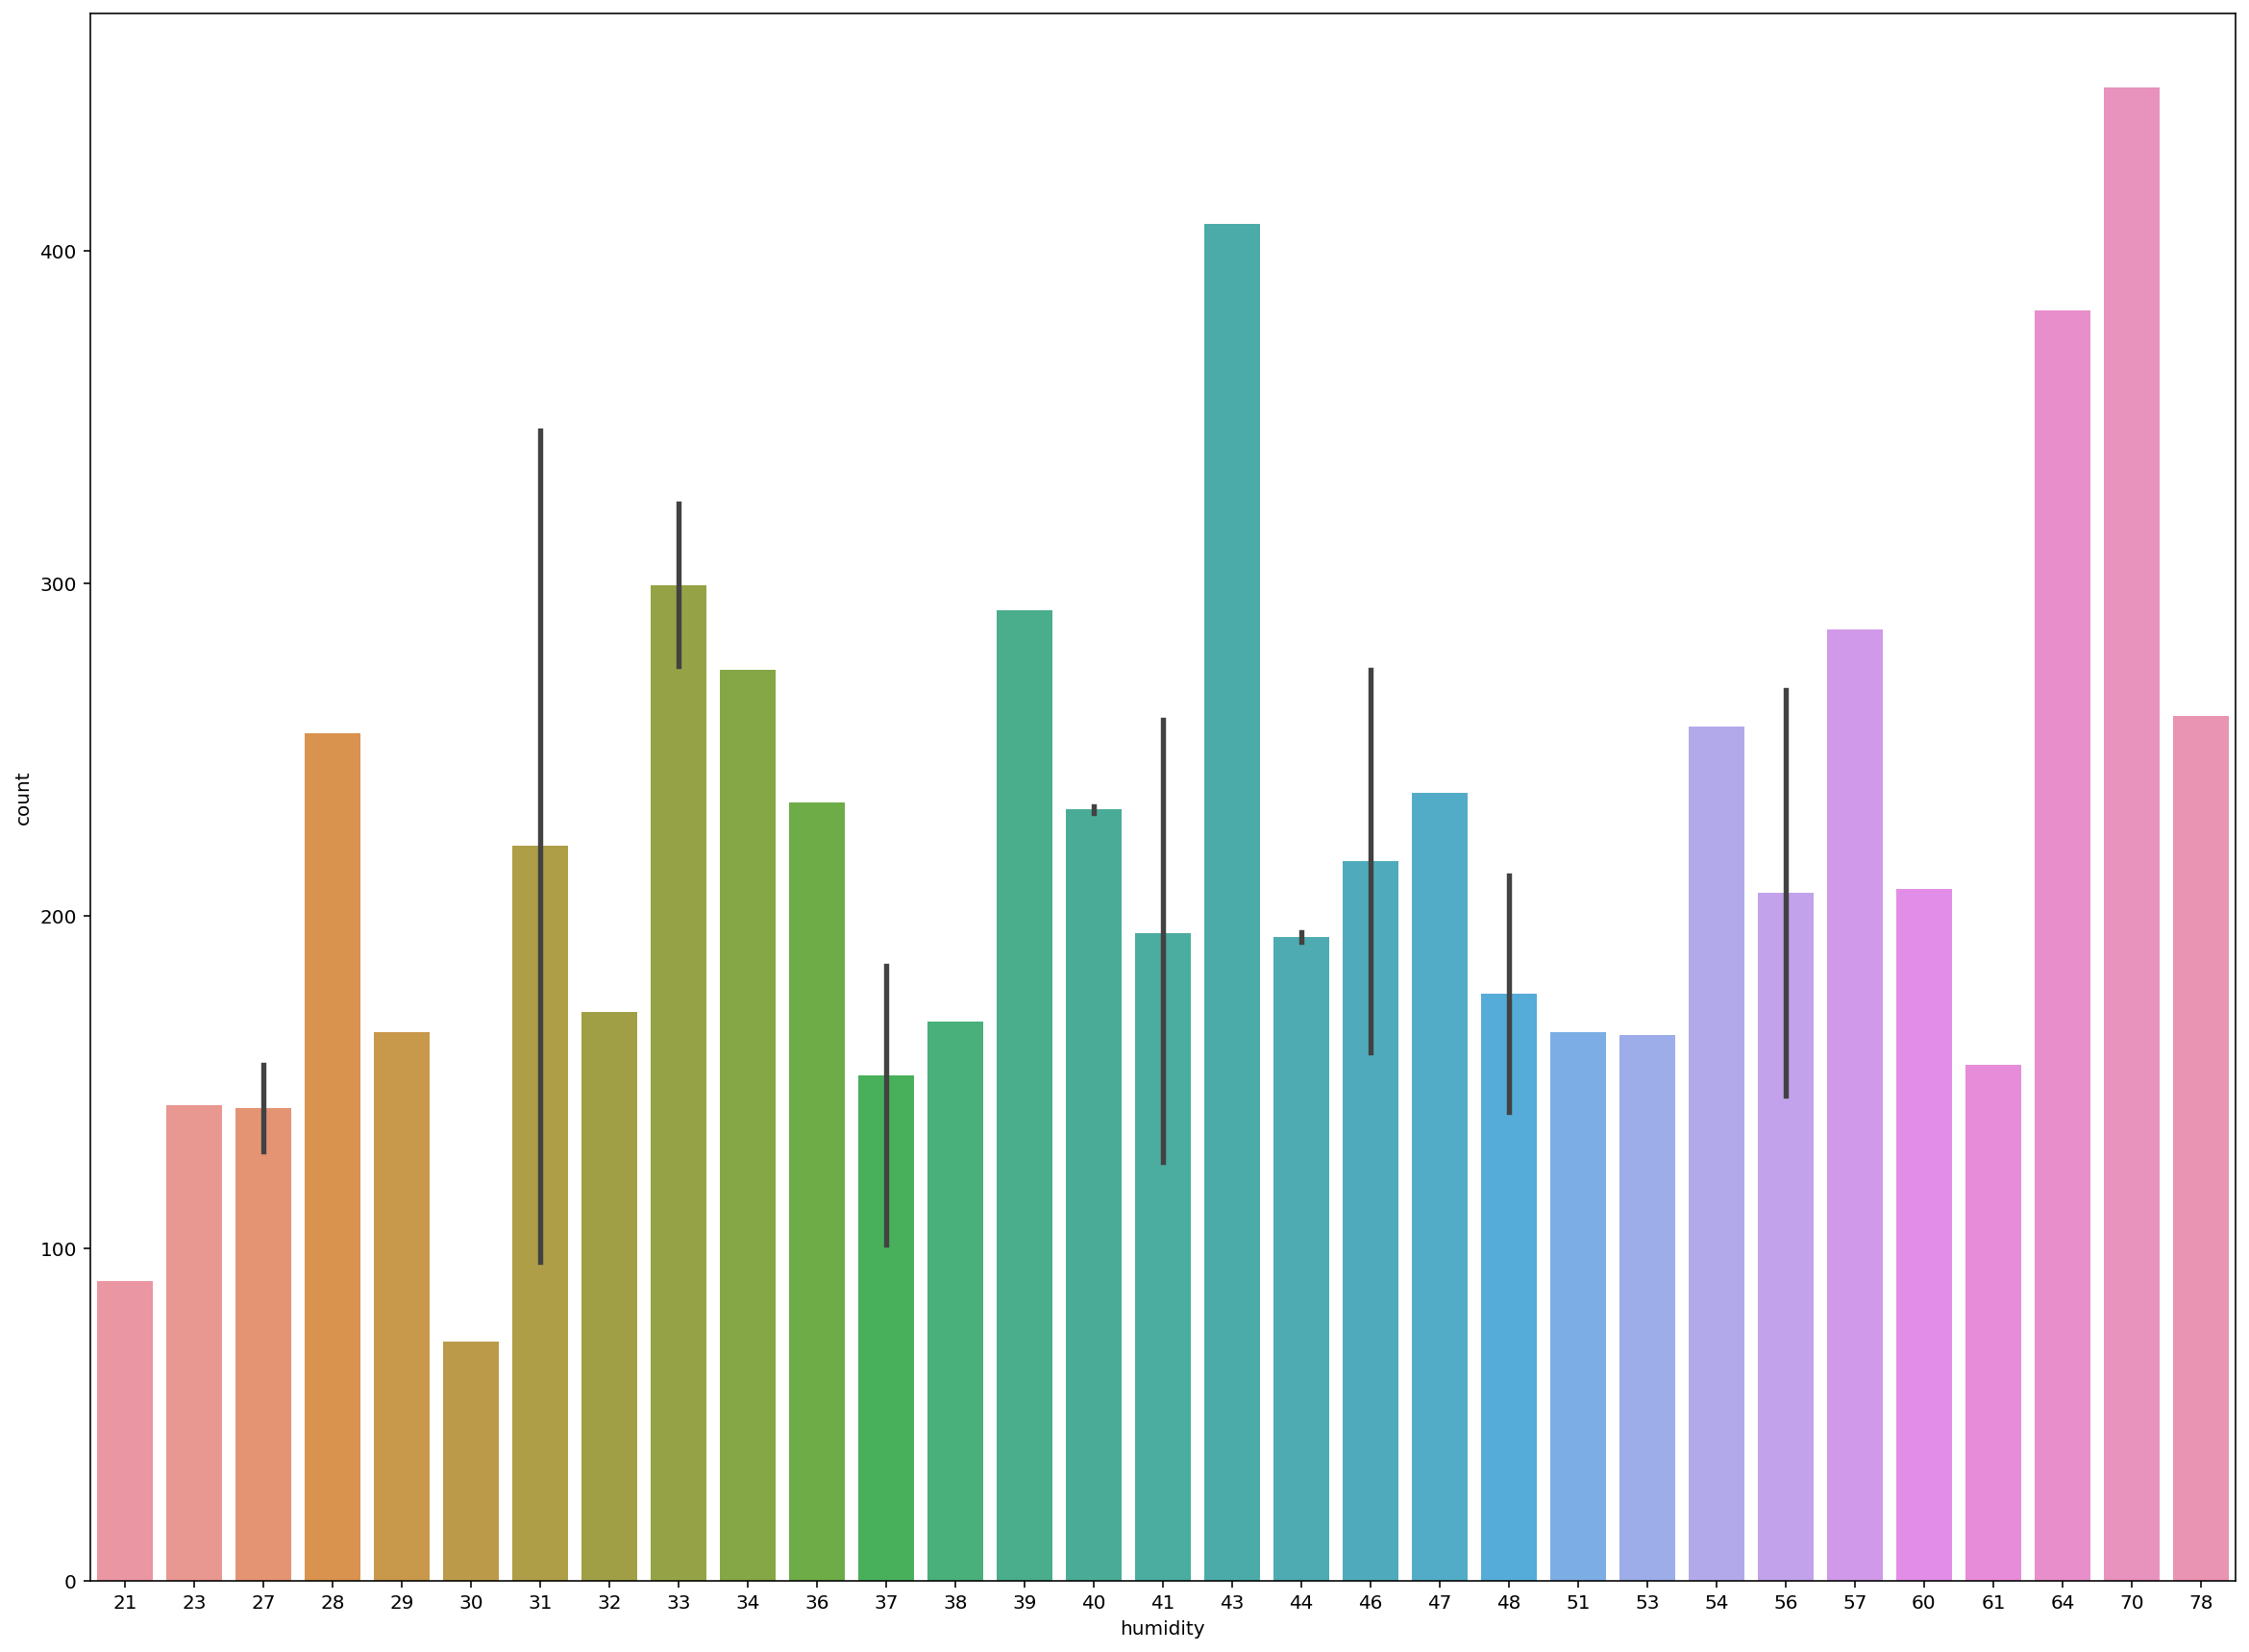

In [553]:
fig = plt.figure(figsize=(20,15))
sns.barplot( x = good_day['humidity'], y = good_day['count'] )
plt.show()

In [554]:
good_day.corrwith(good_day['count'])

season        0.362886
holiday       0.466840
workingday   -0.466840
weather            NaN
temp          0.244704
atemp         0.266266
humidity      0.391506
windspeed    -0.137393
count         1.000000
year          0.604274
month         0.378352
day          -0.071155
hour               NaN
minute             NaN
second             NaN
dayofweek          NaN
dtype: float64

# 회고